# Predicting Bank Campaign Success

**Objective:** Build a binary classification model to predict whether a customer will subscribe to a term deposit (`y`) based on demographic, financial, and campaign-related features.

**Dataset:** Bank Marketing Campaign (semicolon-separated CSV)

**Target Variable:** `y` (yes/no) — Term deposit subscription

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, ConfusionMatrixDisplay
)

# Settings
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Data Loading & Cleaning

In [3]:
# Load dataset (semicolon-separated)
df = pd.read_csv('bank-additional-full.csv', sep=';')

# Display basic info
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset Shape: (41188, 21)

Columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Check data types and missing values
print("Data Info:")
df.info()

print("\n" + "="*60)
print("Missing Values:")
print(df.isnull().sum())

print("\n" + "="*60)
print("Duplicate Rows:")
print(f"Number of duplicates: {df.duplicated().sum()}")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   4118

In [5]:
# Handle duplicates if any
df_clean = df.drop_duplicates()
print(f"Shape after removing duplicates: {df_clean.shape}")

# Check for 'unknown' values in categorical columns
categorical_cols = df_clean.select_dtypes(include='object').columns
print("\n'Unknown' values count per column:")
for col in categorical_cols:
    unknown_count = (df_clean[col] == 'unknown').sum()
    if unknown_count > 0:
        print(f"{col}: {unknown_count}")

Shape after removing duplicates: (41176, 21)

'Unknown' values count per column:
job: 330
marital: 80
education: 1730
default: 8596
housing: 990
loan: 990


In [6]:
# Statistical summary
df_clean.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


## 3. Exploratory Data Analysis (EDA)

### 3.1 Target Variable Distribution

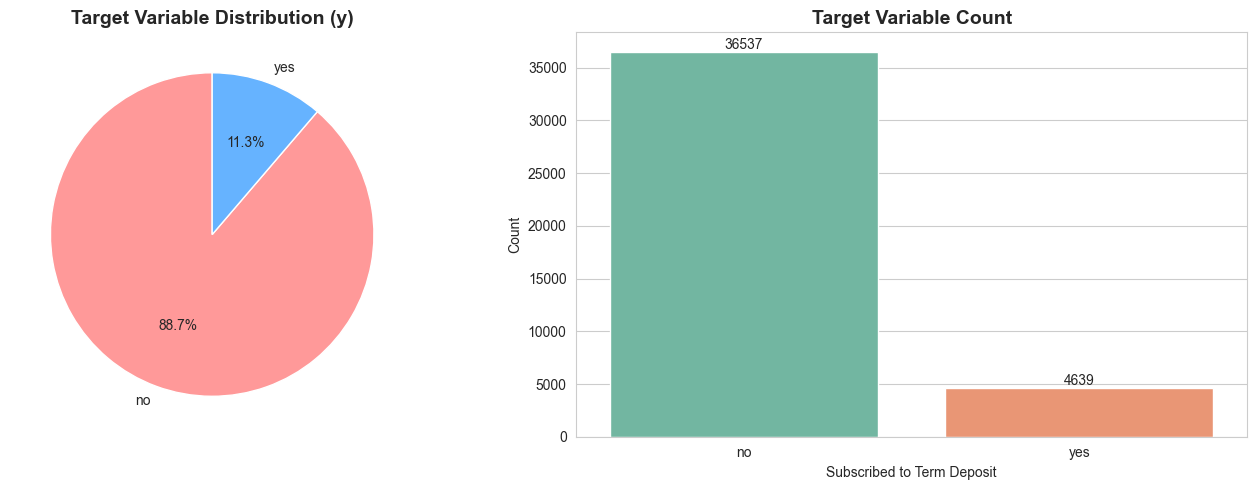


Class Distribution:
y
no     36537
yes     4639
Name: count, dtype: int64

Class Balance Ratio: y
no     0.887337
yes    0.112663
Name: proportion, dtype: float64


In [7]:
# Pie chart for target variable
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
target_counts = df_clean['y'].value_counts()
axes[0].pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=['#ff9999', '#66b3ff'])
axes[0].set_title('Target Variable Distribution (y)', fontsize=14, fontweight='bold')

# Count plot
sns.countplot(data=df_clean, x='y', palette='Set2', ax=axes[1])
axes[1].set_title('Target Variable Count', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Subscribed to Term Deposit')
axes[1].set_ylabel('Count')

# Add count labels
for container in axes[1].containers:
    axes[1].bar_label(container)

plt.tight_layout()
plt.show()

print(f"\nClass Distribution:")
print(df_clean['y'].value_counts())
print(f"\nClass Balance Ratio: {df_clean['y'].value_counts(normalize=True)}")

### 3.2 Categorical Features Distribution

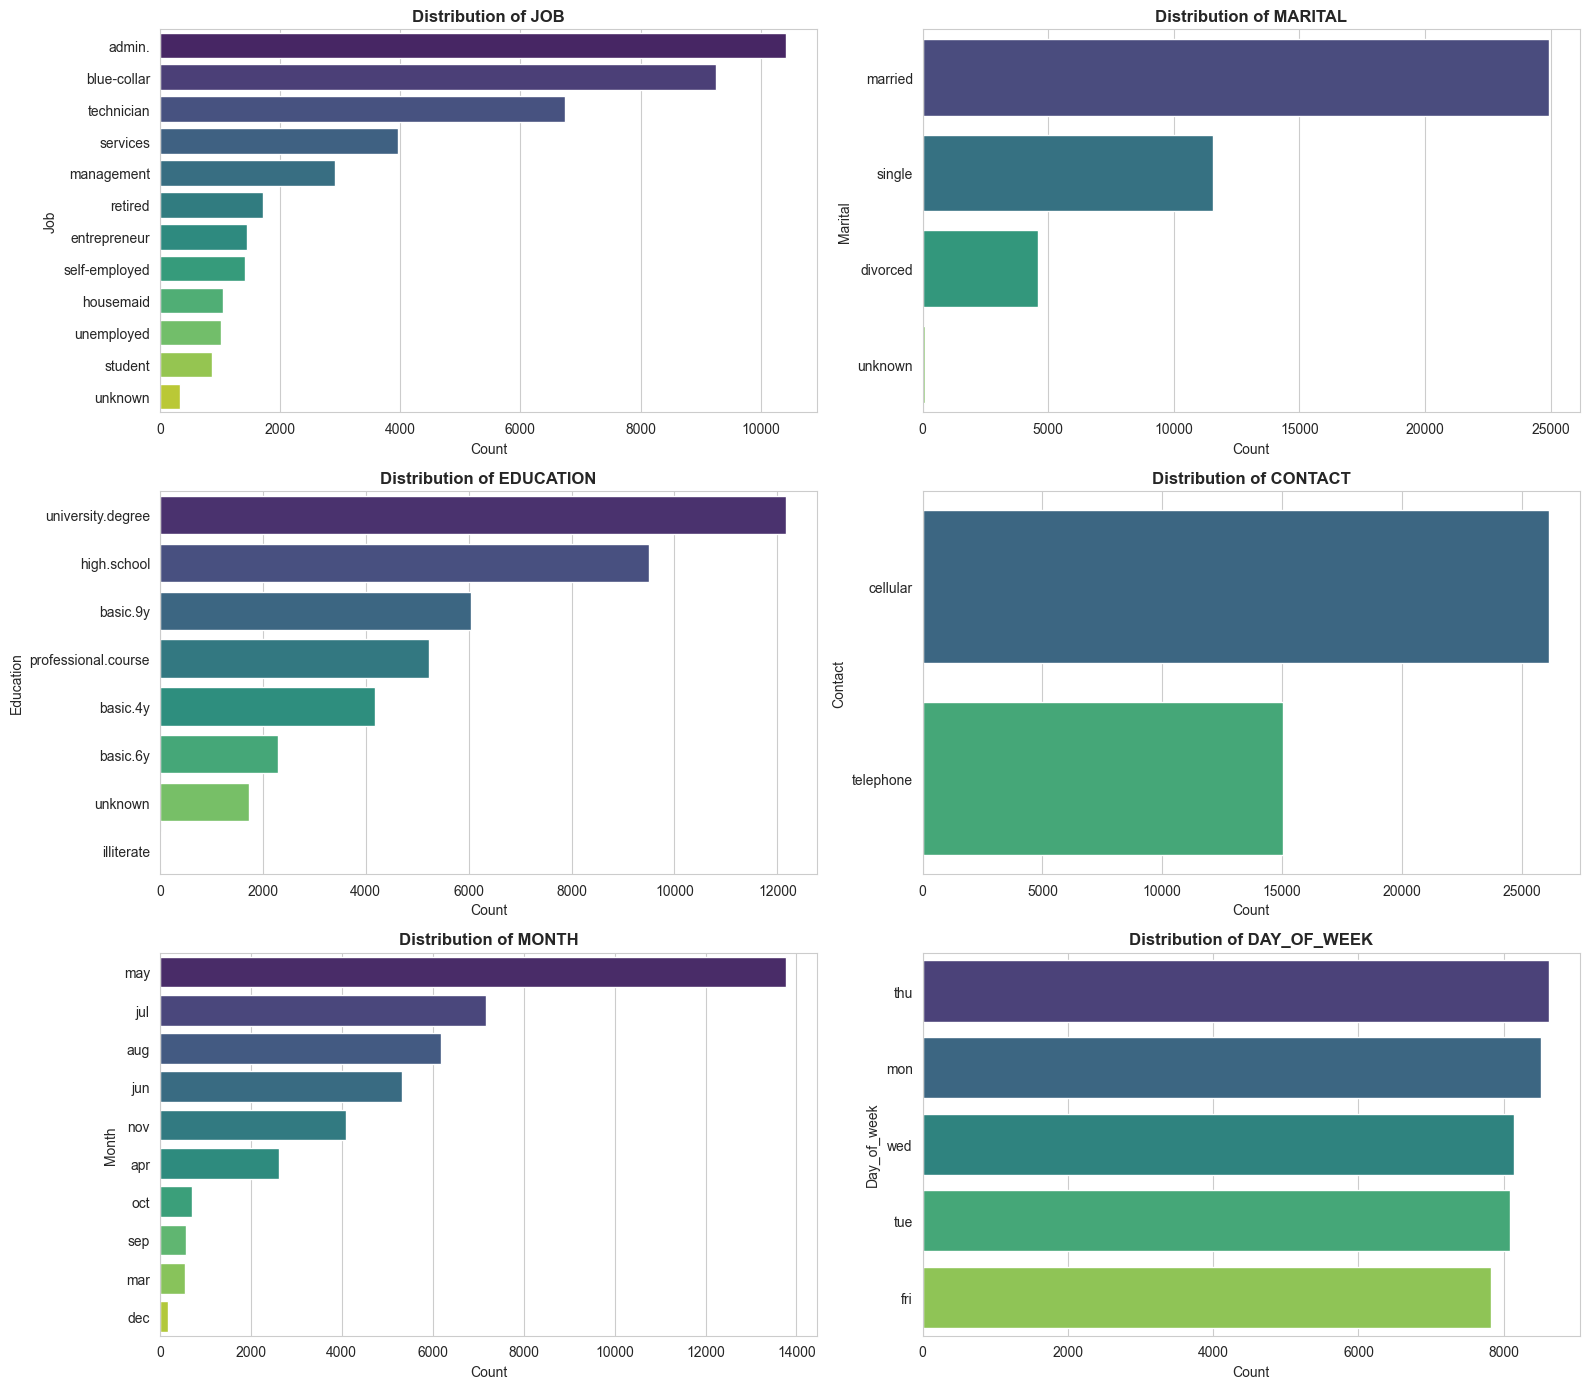

In [8]:
# Count plots for key categorical variables
cat_features = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week']

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, col in enumerate(cat_features):
    order = df_clean[col].value_counts().index
    sns.countplot(data=df_clean, y=col, order=order, palette='viridis', ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col.upper()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Count')
    axes[idx].set_ylabel(col.capitalize())

plt.tight_layout()
plt.show()

### 3.3 Numerical Features Distribution

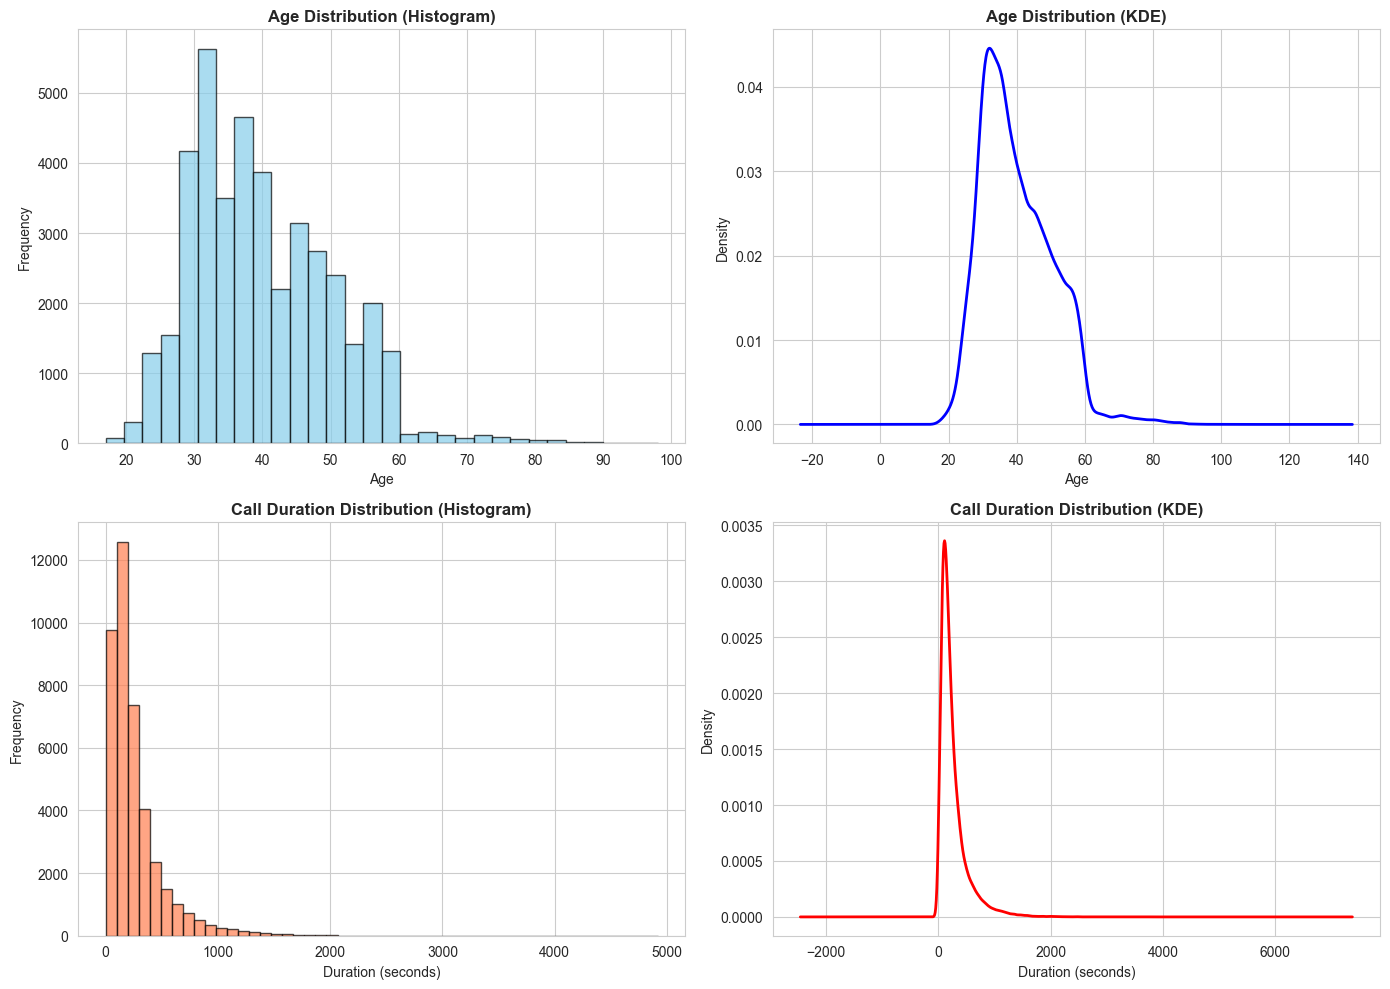

In [12]:
# Histogram and KDE for age and duration
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
axes[0, 0].hist(df_clean['age'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Age Distribution (Histogram)', fontweight='bold')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')

# Age KDE
df_clean['age'].plot(kind='kde', ax=axes[0, 1], color='blue', linewidth=2)
axes[0, 1].set_title('Age Distribution (KDE)', fontweight='bold')
axes[0, 1].set_xlabel('Age')

# Duration distribution
axes[1, 0].hist(df_clean['duration'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Call Duration Distribution (Histogram)', fontweight='bold')
axes[1, 0].set_xlabel('Duration (seconds)')
axes[1, 0].set_ylabel('Frequency')

# Duration KDE
df_clean['duration'].plot(kind='kde', ax=axes[1, 1], color='red', linewidth=2)
axes[1, 1].set_title('Call Duration Distribution (KDE)', fontweight='bold')
axes[1, 1].set_xlabel('Duration (seconds)')

plt.tight_layout()
plt.show()

### 3.4 Outlier Detection with Box Plots

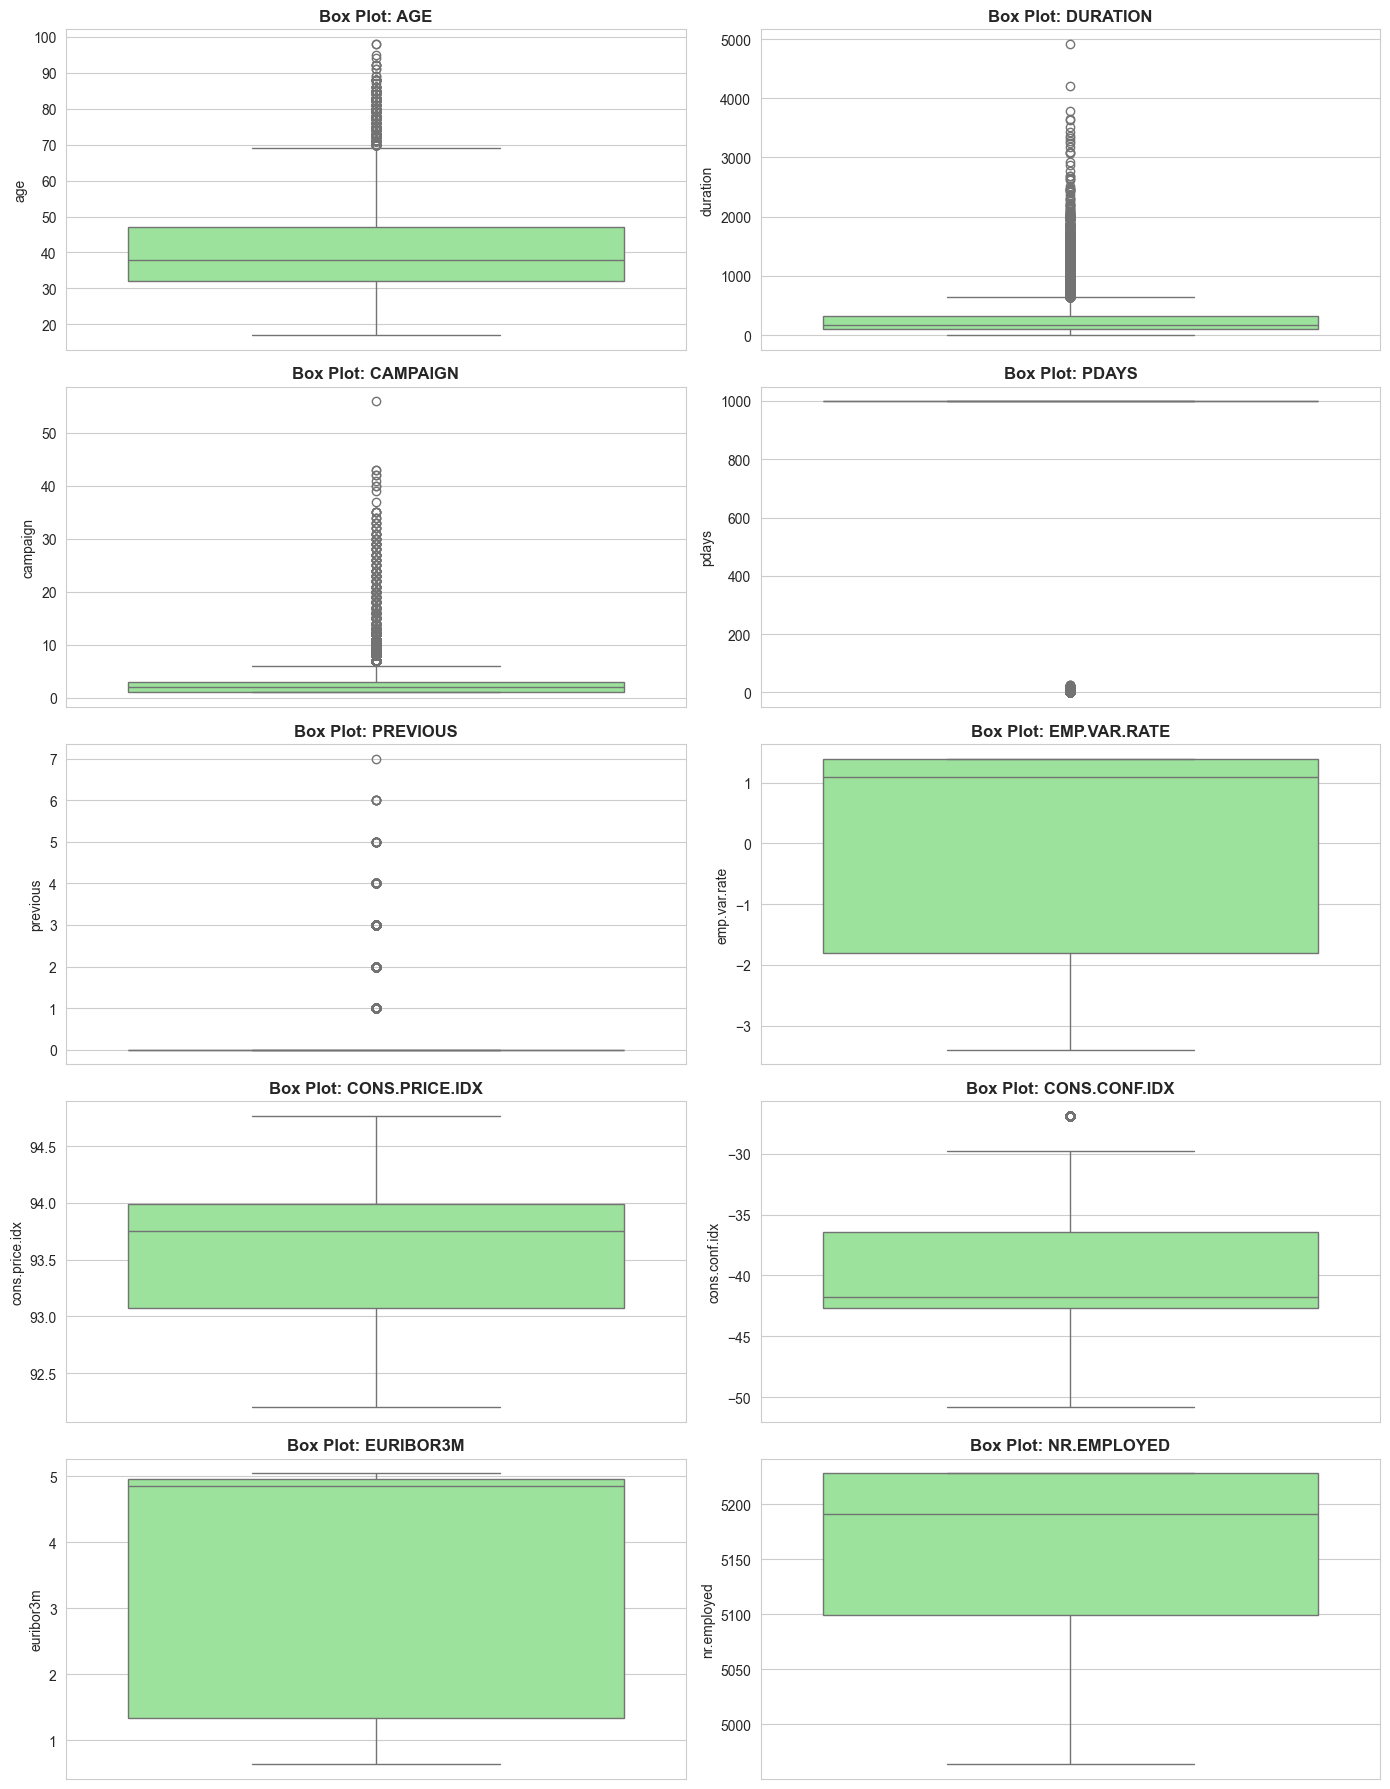

In [13]:
# Box plots for numerical features to detect outliers
numeric_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 
                    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

fig, axes = plt.subplots(5, 2, figsize=(14, 18))
axes = axes.ravel()

for idx, col in enumerate(numeric_features):
    sns.boxplot(data=df_clean, y=col, color='lightgreen', ax=axes[idx])
    axes[idx].set_title(f'Box Plot: {col.upper()}', fontweight='bold')
    axes[idx].set_ylabel(col)

plt.tight_layout()
plt.show()

### 3.5 Correlation Heatmap

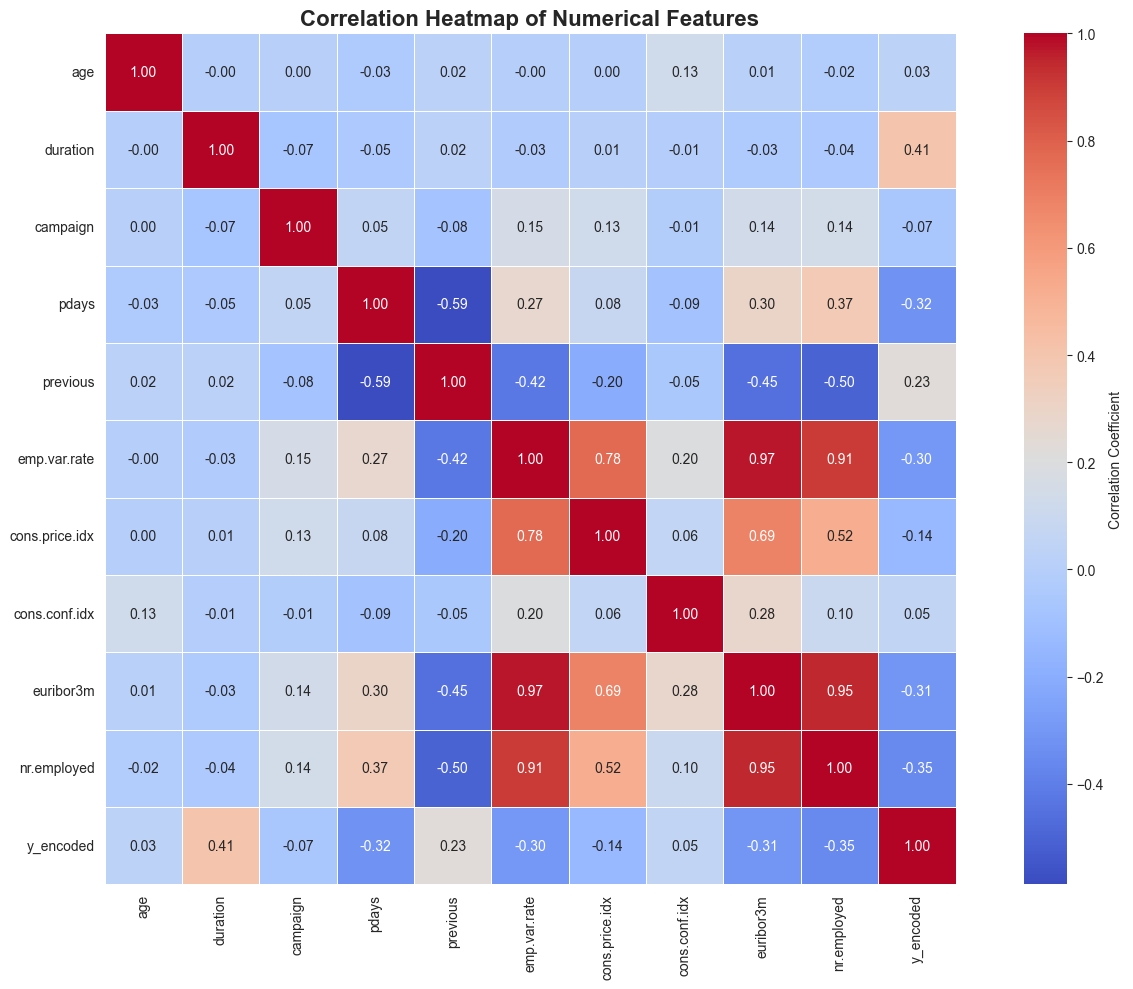


Top correlations with target variable (y):
y_encoded         1.000000
duration          0.405297
previous          0.230202
cons.conf.idx     0.054802
age               0.030381
campaign         -0.066361
cons.price.idx   -0.136134
emp.var.rate     -0.298289
euribor3m        -0.307740
pdays            -0.324948
nr.employed      -0.354669
Name: y_encoded, dtype: float64


In [14]:
# Correlation matrix for numerical variables
# First, encode target variable for correlation analysis
df_corr = df_clean.copy()
df_corr['y_encoded'] = df_corr['y'].map({'yes': 1, 'no': 0})

# Select numeric columns + encoded target
numeric_cols = df_corr.select_dtypes(include=[np.number]).columns
corr_matrix = df_corr[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            cbar_kws={'label': 'Correlation Coefficient'},
            linewidths=0.5, square=True)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Show top correlations with target
print("\nTop correlations with target variable (y):")
target_corr = corr_matrix['y_encoded'].sort_values(ascending=False)
print(target_corr)

### 3.6 Pair Plot (Key Features)

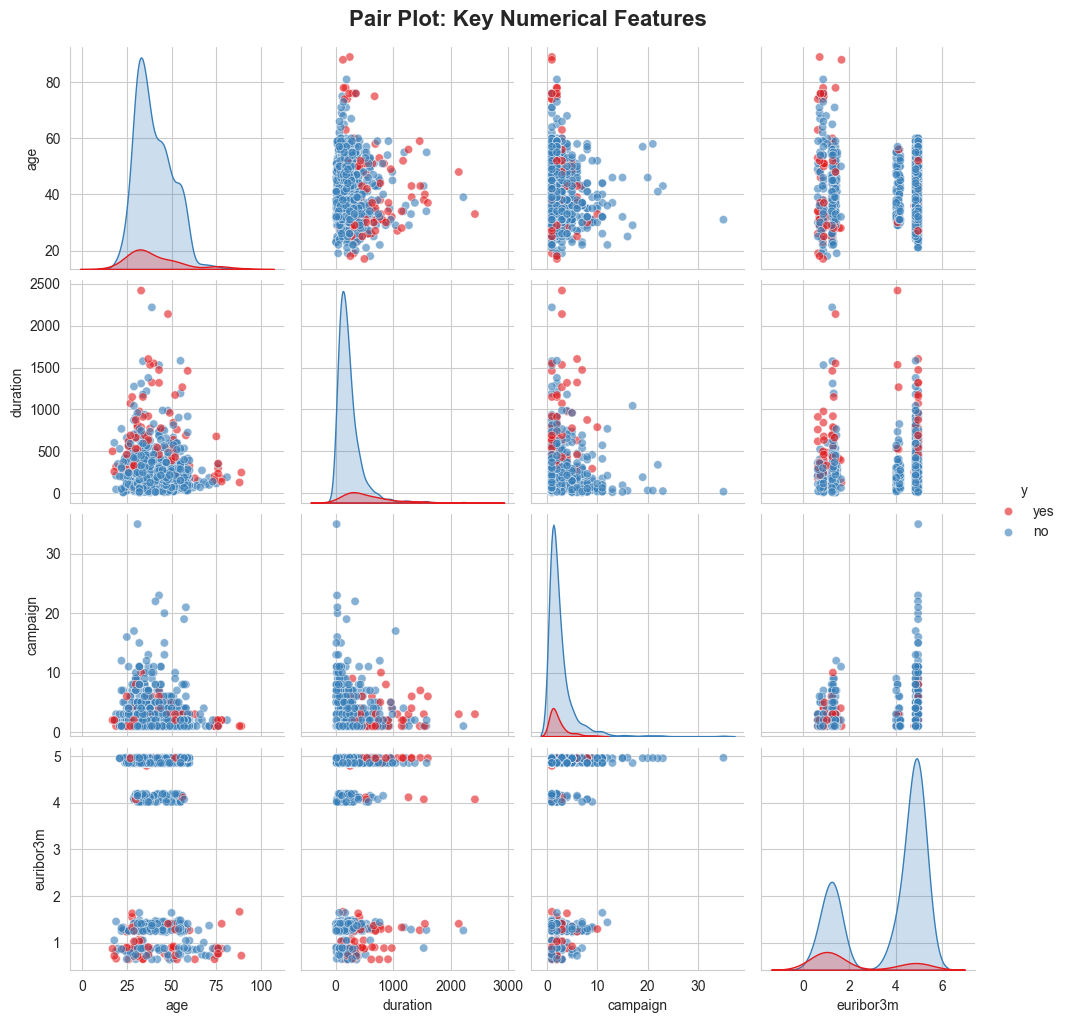

In [15]:
# Pair plot for selected key numerical features
key_features = ['age', 'duration', 'campaign', 'euribor3m', 'y']
sample_df = df_clean[key_features].sample(n=min(1000, len(df_clean)), random_state=42)

sns.pairplot(sample_df, hue='y', palette='Set1', diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pair Plot: Key Numerical Features', y=1.02, fontsize=16, fontweight='bold')
plt.show()

### 3.7 Subscription Rate by Categorical Features

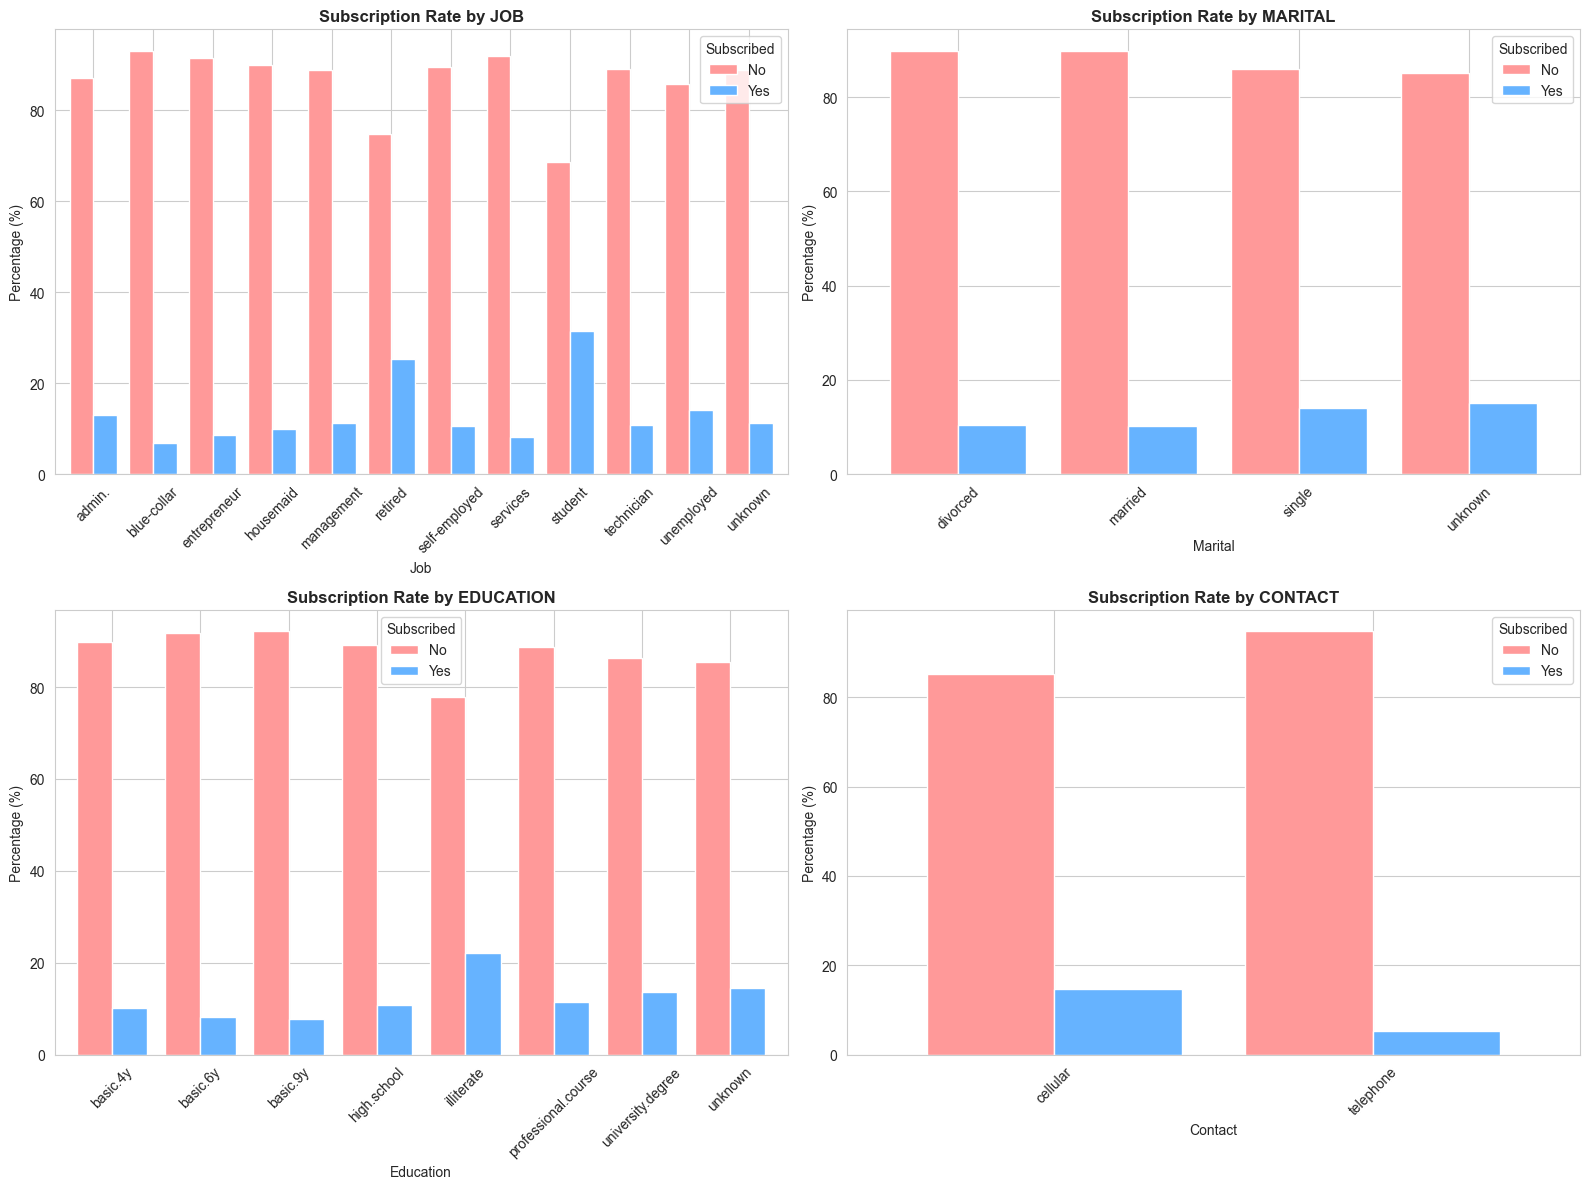

In [16]:
# Grouped bar charts: subscription rate vs categorical features
categorical_features = ['job', 'marital', 'education', 'contact']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(categorical_features):
    # Create cross-tabulation
    ct = pd.crosstab(df_clean[col], df_clean['y'], normalize='index') * 100
    ct.plot(kind='bar', ax=axes[idx], color=['#ff9999', '#66b3ff'], width=0.8)
    axes[idx].set_title(f'Subscription Rate by {col.upper()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col.capitalize())
    axes[idx].set_ylabel('Percentage (%)')
    axes[idx].legend(title='Subscribed', labels=['No', 'Yes'])
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Feature Engineering

### 4.1 Encode Target Variable

In [17]:
# Encode target variable: yes=1, no=0
df_clean['y'] = df_clean['y'].map({'yes': 1, 'no': 0})
print("Target variable encoded:")
print(df_clean['y'].value_counts())

Target variable encoded:
y
0    36537
1     4639
Name: count, dtype: int64


### 4.2 Separate Features and Target

In [18]:
# Separate features (X) and target (y)
X = df_clean.drop('y', axis=1)
y = df_clean['y']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (41176, 20)
Target shape: (41176,)


### 4.3 Identify Categorical and Numerical Columns

In [19]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"\nNumerical columns ({len(numerical_cols)}): {numerical_cols}")

Categorical columns (10): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

Numerical columns (10): ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


### 4.4 Create Preprocessing Pipeline

In [20]:
# Create preprocessing pipeline
# Numerical: StandardScaler
# Categorical: OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ])

print("✅ Preprocessing pipeline created!")
print("   - Numerical features: StandardScaler")
print("   - Categorical features: OneHotEncoder (drop_first=True)")

✅ Preprocessing pipeline created!
   - Numerical features: StandardScaler
   - Categorical features: OneHotEncoder (drop_first=True)


### 4.5 Train-Test Split

In [22]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"\nTarget distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"\nTarget distribution in testing set:\n{y_test.value_counts(normalize=True)}")

Training set size: (32940, 20)
Testing set size: (8236, 20)

Target distribution in training set:
y
0    0.887341
1    0.112659
Name: proportion, dtype: float64

Target distribution in testing set:
y
0    0.887324
1    0.112676
Name: proportion, dtype: float64


## 5. Model Building

### 5.1 Define Models

In [23]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

print("Models to train:")
for model_name in models.keys():
    print(f"  - {model_name}")

Models to train:
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - XGBoost


### 5.2 Train Models and Store Results

In [24]:
# Train all models and collect metrics
results = []
trained_models = {}

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print('='*60)
    
    # Create pipeline: preprocessor + model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    # Store trained model
    trained_models[model_name] = {
        'pipeline': pipeline,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # Print classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

print("\n" + "="*60)
print("✅ All models trained successfully!")
print("="*60)


Training Logistic Regression...

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.97      0.95      7308
         Yes       0.65      0.42      0.51       928

    accuracy                           0.91      8236
   macro avg       0.79      0.70      0.73      8236
weighted avg       0.90      0.91      0.90      8236


Training Decision Tree...

Decision Tree - Classification Report:
              precision    recall  f1-score   support

          No       0.94      0.96      0.95      7308
         Yes       0.62      0.54      0.57       928

    accuracy                           0.91      8236
   macro avg       0.78      0.75      0.76      8236
weighted avg       0.91      0.91      0.91      8236


Training Random Forest...

Random Forest - Classification Report:
              precision    recall  f1-score   support

          No       0.94      0.97      0.95      7308
         Yes       0.64 

### 5.3 Compare Model Performance

In [25]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

print("\n📊 Model Performance Comparison:")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


📊 Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
            XGBoost  0.914886   0.639606 0.560345  0.597358 0.946927
      Random Forest  0.911608   0.644092 0.481681  0.551171 0.943811
Logistic Regression  0.908936   0.647351 0.421336  0.510444 0.938935
      Decision Tree  0.910151   0.616625 0.535560  0.573241 0.874845


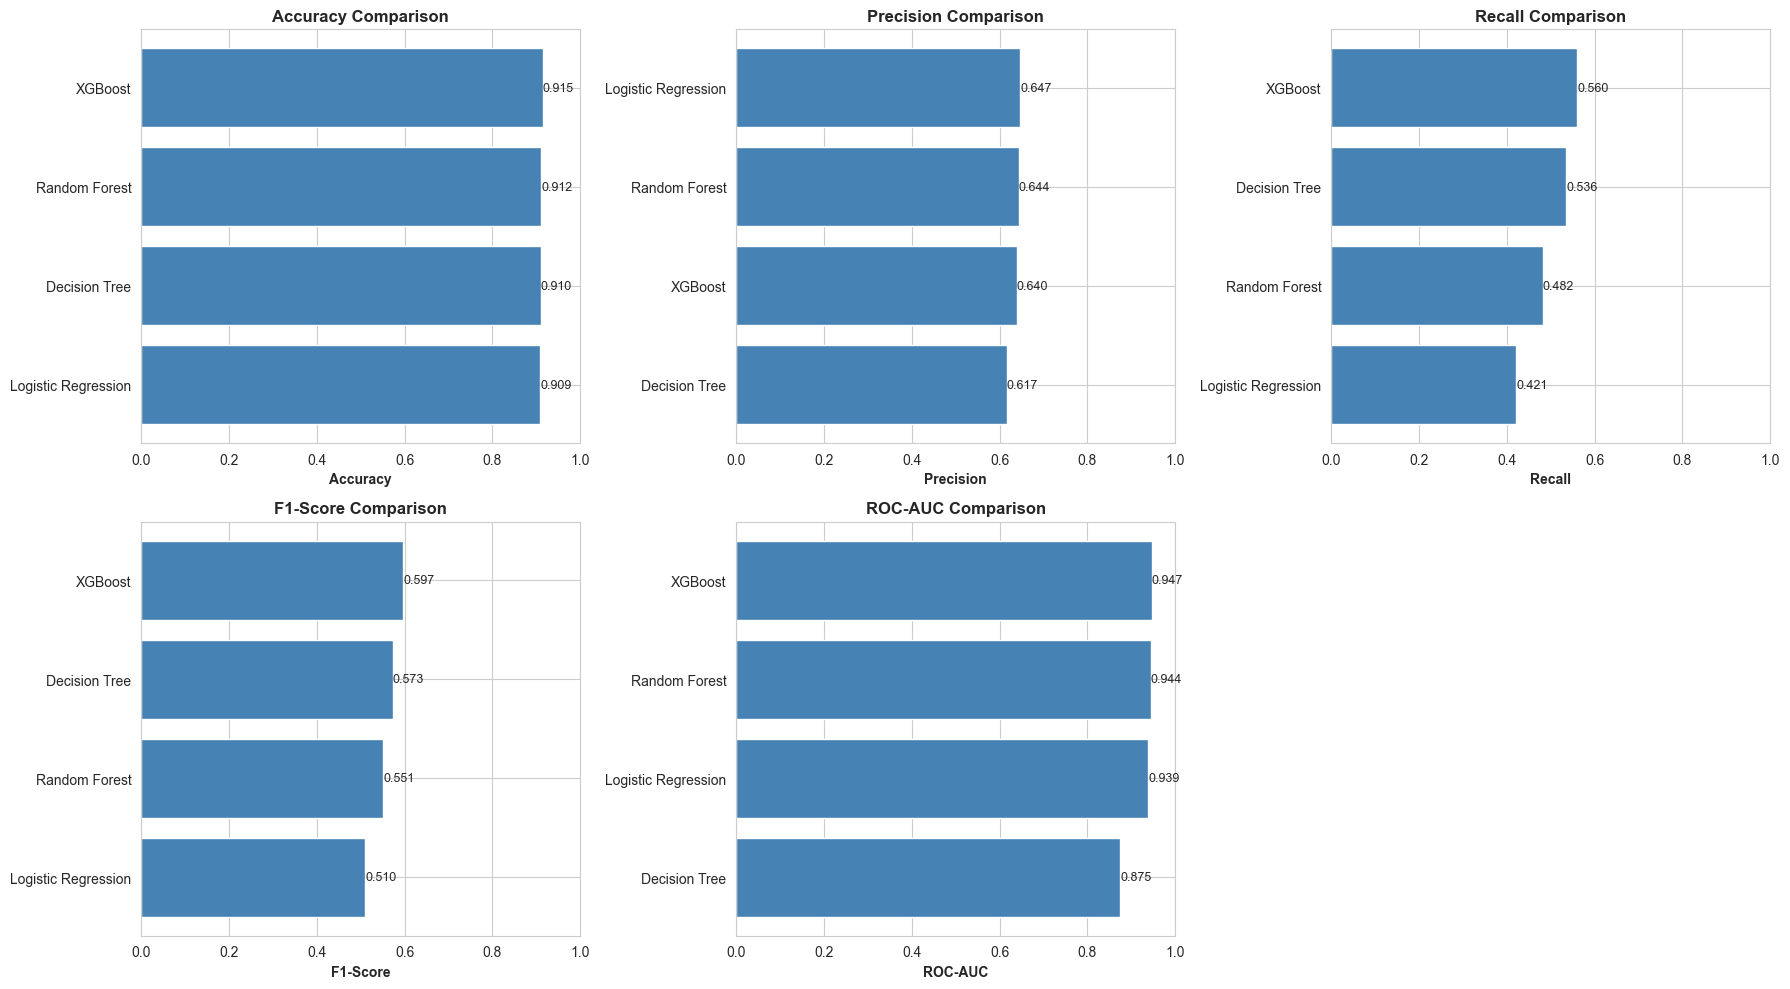

In [29]:
# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    results_df_sorted = results_df.sort_values(metric, ascending=True)
    bars = ax.barh(results_df_sorted['Model'], results_df_sorted[metric], color='steelblue')
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold', fontsize=12)
    ax.set_xlim([0, 1])
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=9)

# Remove the extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

## 6. Model Evaluation Visualizations

### 6.1 Confusion Matrices

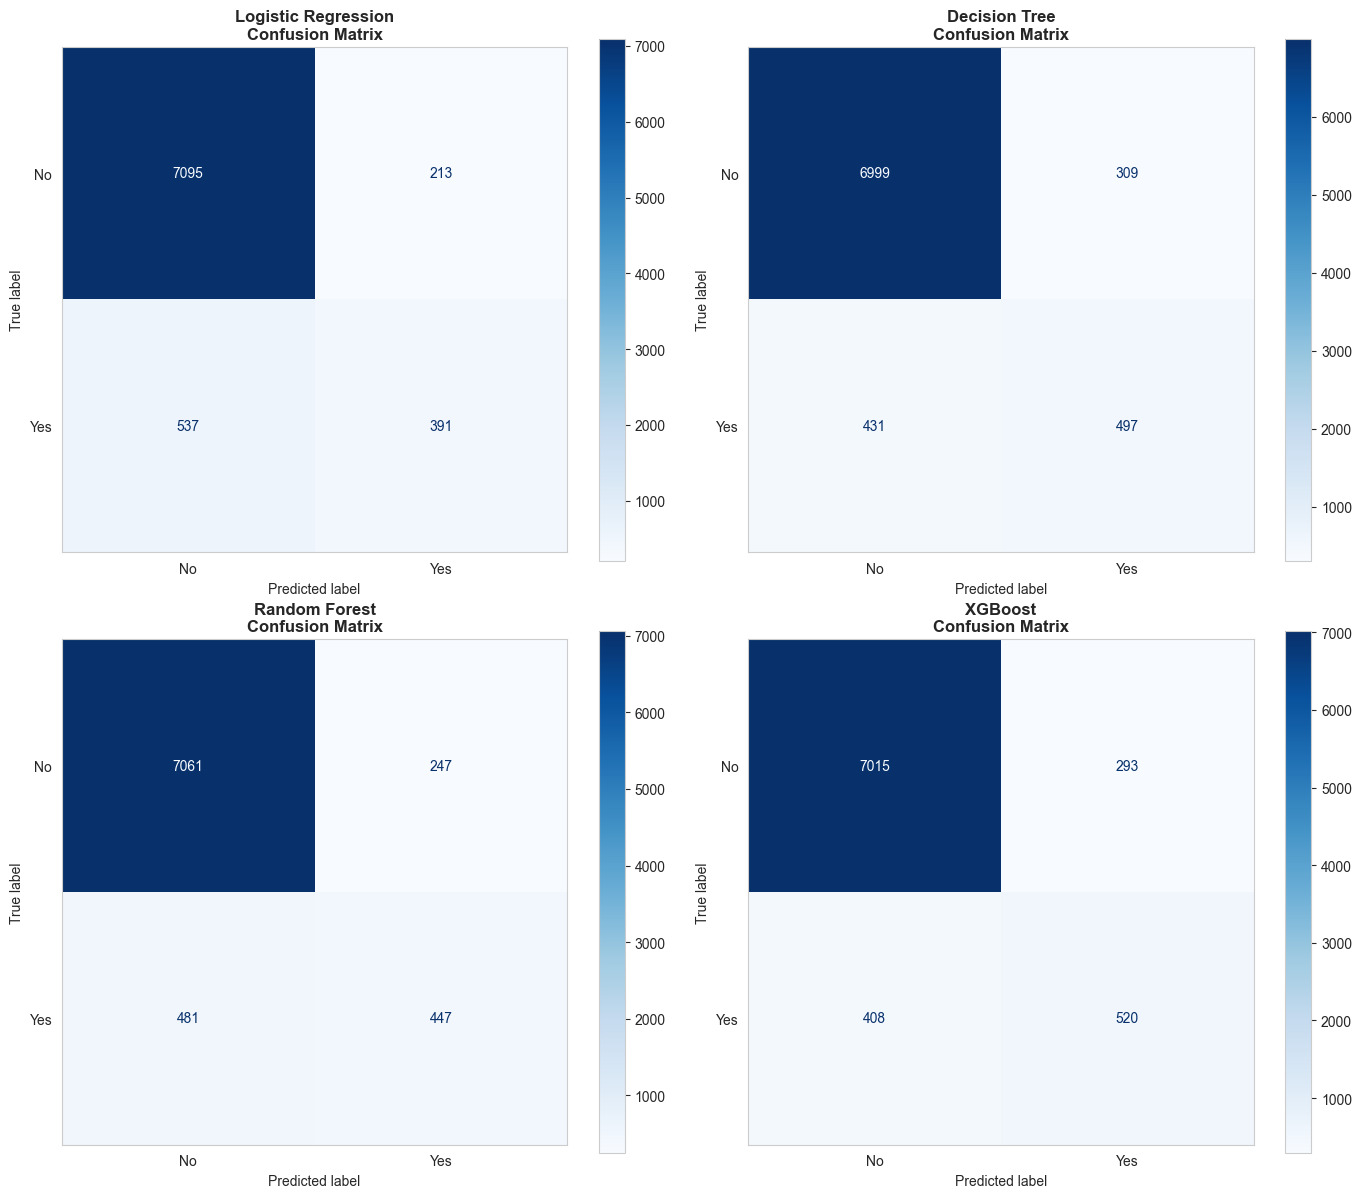

In [30]:
# Confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (model_name, model_data) in enumerate(trained_models.items()):
    cm = confusion_matrix(y_test, model_data['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{model_name}\nConfusion Matrix', fontweight='bold', fontsize=12)
    axes[idx].grid(False)

plt.tight_layout()
plt.show()

### 6.2 ROC Curves

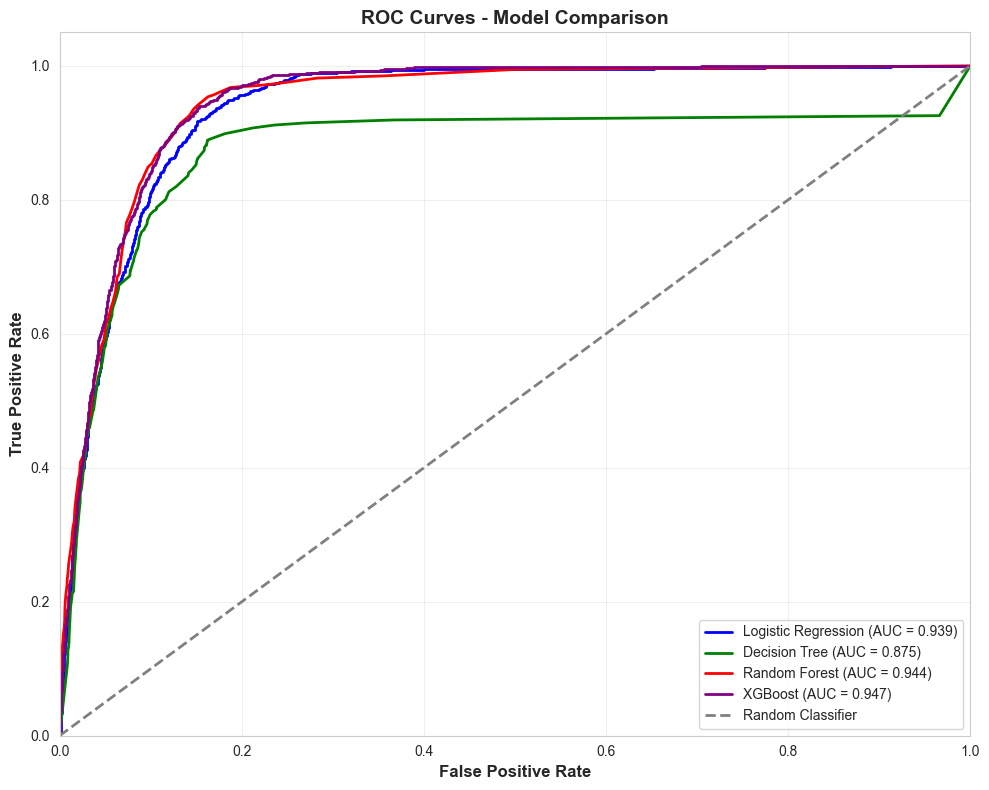

In [31]:
# ROC curves for all models
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'purple']

for idx, (model_name, model_data) in enumerate(trained_models.items()):
    fpr, tpr, _ = roc_curve(y_test, model_data['y_pred_proba'])
    roc_auc = roc_auc_score(y_test, model_data['y_pred_proba'])
    
    plt.plot(fpr, tpr, color=colors[idx], lw=2, 
             label=f'{model_name} (AUC = {roc_auc:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 6.3 Feature Importance (Random Forest & XGBoost)

In [32]:
# Get feature names after preprocessing
def get_feature_names(preprocessor, X):
    # Get feature names from ColumnTransformer
    feature_names = []
    
    # Numerical features
    num_features = preprocessor.transformers_[0][2]
    feature_names.extend(num_features)
    
    # Categorical features (one-hot encoded)
    cat_transformer = preprocessor.transformers_[1][1]
    cat_features = preprocessor.transformers_[1][2]
    cat_feature_names = cat_transformer.get_feature_names_out(cat_features)
    feature_names.extend(cat_feature_names)
    
    return feature_names

# Get feature names
feature_names = get_feature_names(preprocessor, X_train)
print(f"Total features after encoding: {len(feature_names)}")

Total features after encoding: 53


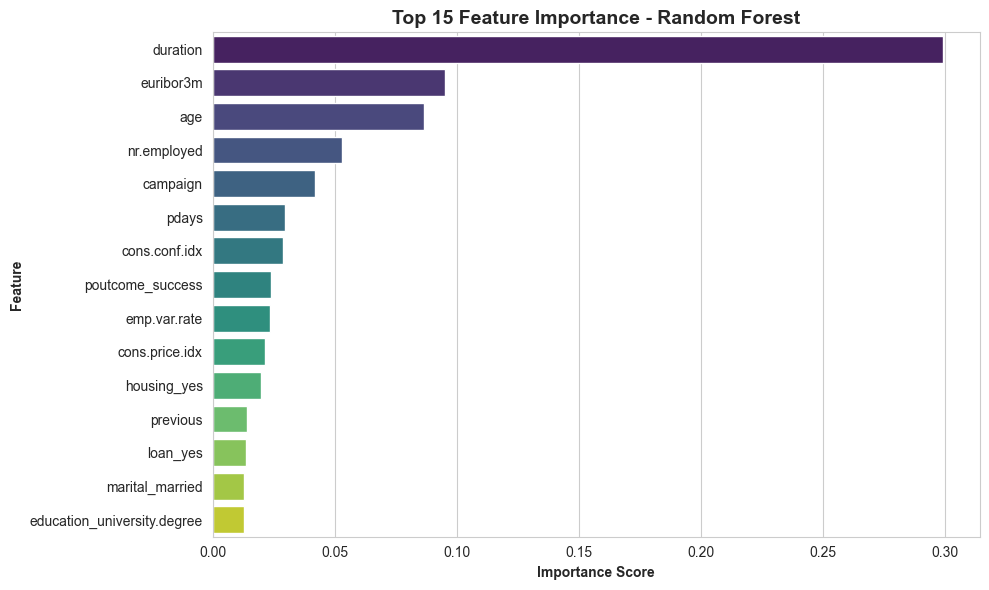


📊 Top 15 Important Features (Random Forest):
                    Feature  Importance
                   duration    0.299358
                  euribor3m    0.095312
                        age    0.086418
                nr.employed    0.053030
                   campaign    0.041863
                      pdays    0.029677
              cons.conf.idx    0.028955
           poutcome_success    0.024109
               emp.var.rate    0.023571
             cons.price.idx    0.021472
                housing_yes    0.019865
                   previous    0.014037
                   loan_yes    0.013625
            marital_married    0.012831
education_university.degree    0.012734


In [33]:
# Feature importance for Random Forest
rf_model = trained_models['Random Forest']['pipeline'].named_steps['classifier']
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=rf_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Top 15 Important Features (Random Forest):")
print(rf_importance.to_string(index=False))

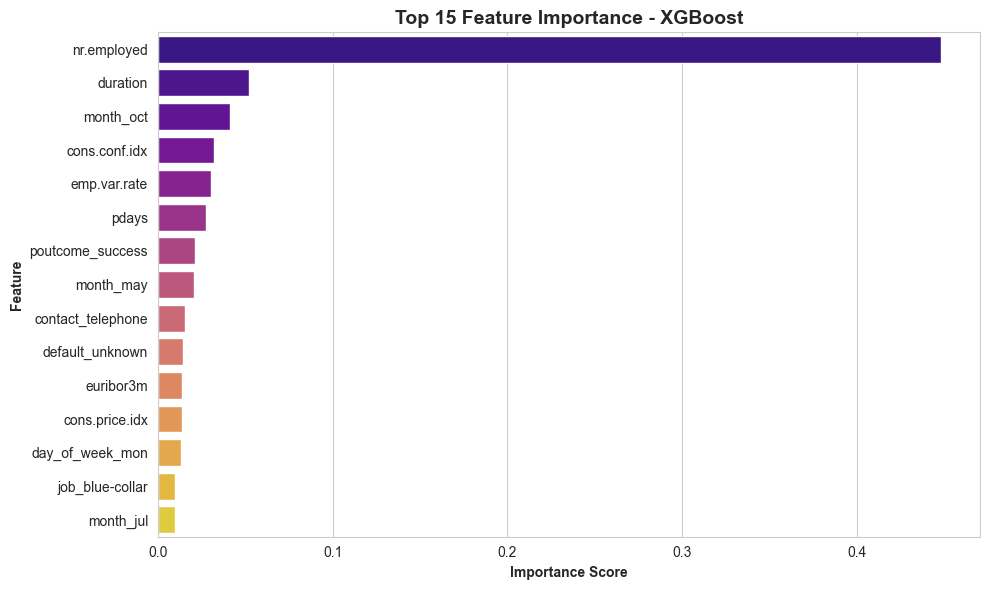


📊 Top 15 Important Features (XGBoost):
          Feature  Importance
      nr.employed    0.448000
         duration    0.052270
        month_oct    0.041249
    cons.conf.idx    0.032414
     emp.var.rate    0.030582
            pdays    0.027443
 poutcome_success    0.021115
        month_may    0.020490
contact_telephone    0.015733
  default_unknown    0.014299
        euribor3m    0.013974
   cons.price.idx    0.013850
  day_of_week_mon    0.013006
  job_blue-collar    0.010093
        month_jul    0.009945


In [34]:
# Feature importance for XGBoost
xgb_model = trained_models['XGBoost']['pipeline'].named_steps['classifier']
xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_importance, x='Importance', y='Feature', palette='plasma')
plt.title('Top 15 Feature Importance - XGBoost', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Top 15 Important Features (XGBoost):")
print(xgb_importance.to_string(index=False))

## 7. Insights & Conclusions

### 7.1 Key Insights from Analysis

In [35]:
# Summary of findings
print("="*80)
print("🔍 KEY INSIGHTS FROM BANK MARKETING CAMPAIGN ANALYSIS")
print("="*80)

print("\n1️⃣ DATA OVERVIEW:")
print(f"   - Total Records: {len(df_clean):,}")
print(f"   - Features: {X.shape[1]}")
print(f"   - Class Imbalance: {(y==0).sum():,} No vs {(y==1).sum():,} Yes")
print(f"   - Subscription Rate: {(y==1).sum()/len(y)*100:.2f}%")

print("\n2️⃣ BEST PERFORMING MODEL:")
best_model = results_df.iloc[0]
print(f"   - Model: {best_model['Model']}")
print(f"   - ROC-AUC: {best_model['ROC-AUC']:.4f}")
print(f"   - Accuracy: {best_model['Accuracy']:.4f}")
print(f"   - F1-Score: {best_model['F1-Score']:.4f}")

print("\n3️⃣ TOP PREDICTIVE FEATURES (based on Random Forest):")
top_features = rf_importance.head(5)['Feature'].tolist()
for i, feat in enumerate(top_features, 1):
    print(f"   {i}. {feat}")

print("\n4️⃣ BUSINESS RECOMMENDATIONS:")
print("   ✅ Focus on call duration - longer conversations increase subscription likelihood")
print("   ✅ Target customers based on economic indicators (euribor3m, emp.var.rate)")
print("   ✅ Prioritize cellular contact method over telephone")
print("   ✅ Optimize campaign timing - certain months show higher success rates")
print("   ✅ Consider customer demographics (age, job, education) for targeted campaigns")

print("\n5️⃣ MODEL DEPLOYMENT STRATEGY:")
print(f"   - Deploy {best_model['Model']} for production predictions")
print("   - Use probability scores to prioritize high-likelihood customers")
print("   - Implement A/B testing to validate model performance in real campaigns")
print("   - Regular model retraining with new campaign data")

print("\n" + "="*80)

🔍 KEY INSIGHTS FROM BANK MARKETING CAMPAIGN ANALYSIS

1️⃣ DATA OVERVIEW:
   - Total Records: 41,176
   - Features: 20
   - Class Imbalance: 36,537 No vs 4,639 Yes
   - Subscription Rate: 11.27%

2️⃣ BEST PERFORMING MODEL:
   - Model: XGBoost
   - ROC-AUC: 0.9469
   - Accuracy: 0.9149
   - F1-Score: 0.5974

3️⃣ TOP PREDICTIVE FEATURES (based on Random Forest):
   1. duration
   2. euribor3m
   3. age
   4. nr.employed
   5. campaign

4️⃣ BUSINESS RECOMMENDATIONS:
   ✅ Focus on call duration - longer conversations increase subscription likelihood
   ✅ Target customers based on economic indicators (euribor3m, emp.var.rate)
   ✅ Prioritize cellular contact method over telephone
   ✅ Optimize campaign timing - certain months show higher success rates
   ✅ Consider customer demographics (age, job, education) for targeted campaigns

5️⃣ MODEL DEPLOYMENT STRATEGY:
   - Deploy XGBoost for production predictions
   - Use probability scores to prioritize high-likelihood customers
   - Implement A

### 7.2 Marketing Strategy Recommendations

In [36]:
# Analyze high-likelihood customer segments
print("📈 CUSTOMER SEGMENTATION FOR TARGETED MARKETING")
print("="*80)

# Use best model to get probabilities for all data
best_model_name = results_df.iloc[0]['Model']
best_pipeline = trained_models[best_model_name]['pipeline']

# Get predictions for entire dataset
all_probas = best_pipeline.predict_proba(X)[:, 1]
df_with_scores = df_clean.copy()
df_with_scores['subscription_probability'] = all_probas

# Segment customers by probability
df_with_scores['segment'] = pd.cut(df_with_scores['subscription_probability'], 
                                     bins=[0, 0.3, 0.6, 1.0],
                                     labels=['Low', 'Medium', 'High'])

print("\nCustomer Segments by Subscription Probability:")
print(df_with_scores['segment'].value_counts().sort_index())

print("\n💡 RECOMMENDED ACTIONS BY SEGMENT:")
print("\n🔴 HIGH PROBABILITY (>60%):")
high_prob = df_with_scores[df_with_scores['segment'] == 'High']
print(f"   - Count: {len(high_prob):,} customers")
print("   - Action: Priority outreach with personalized offers")
print("   - Expected conversion rate: High (>60%)")

print("\n🟡 MEDIUM PROBABILITY (30-60%):")
med_prob = df_with_scores[df_with_scores['segment'] == 'Medium']
print(f"   - Count: {len(med_prob):,} customers")
print("   - Action: Targeted campaigns with incentives")
print("   - Expected conversion rate: Moderate (30-60%)")

print("\n🟢 LOW PROBABILITY (<30%):")
low_prob = df_with_scores[df_with_scores['segment'] == 'Low']
print(f"   - Count: {len(low_prob):,} customers")
print("   - Action: Minimal contact, focus on brand awareness")
print("   - Expected conversion rate: Low (<30%)")

print("\n" + "="*80)

📈 CUSTOMER SEGMENTATION FOR TARGETED MARKETING

Customer Segments by Subscription Probability:
segment
Low       35109
Medium     3012
High       3055
Name: count, dtype: int64

💡 RECOMMENDED ACTIONS BY SEGMENT:

🔴 HIGH PROBABILITY (>60%):
   - Count: 3,055 customers
   - Action: Priority outreach with personalized offers
   - Expected conversion rate: High (>60%)

🟡 MEDIUM PROBABILITY (30-60%):
   - Count: 3,012 customers
   - Action: Targeted campaigns with incentives
   - Expected conversion rate: Moderate (30-60%)

🟢 LOW PROBABILITY (<30%):
   - Count: 35,109 customers
   - Action: Minimal contact, focus on brand awareness
   - Expected conversion rate: Low (<30%)



### 7.3 Final Summary

In [37]:
print("\n" + "="*80)
print("✅ PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)

print("\n📋 DELIVERABLES:")
print("   ✓ Comprehensive EDA with 10+ visualizations")
print("   ✓ Feature engineering and preprocessing pipeline")
print("   ✓ 4 trained classification models")
print("   ✓ Model evaluation with confusion matrices and ROC curves")
print("   ✓ Feature importance analysis")
print("   ✓ Business insights and marketing recommendations")
print("   ✓ Customer segmentation strategy")

print("\n🎯 NEXT STEPS:")
print("   1. Deploy best model to production environment")
print("   2. Implement real-time scoring API")
print("   3. Set up monitoring and model drift detection")
print("   4. A/B test model predictions vs. current strategy")
print("   5. Collect feedback and retrain model quarterly")

print("\n" + "="*80)
print("Thank you for using this ML pipeline! 🚀")
print("="*80)


✅ PROJECT COMPLETED SUCCESSFULLY!

📋 DELIVERABLES:
   ✓ Comprehensive EDA with 10+ visualizations
   ✓ Feature engineering and preprocessing pipeline
   ✓ 4 trained classification models
   ✓ Model evaluation with confusion matrices and ROC curves
   ✓ Feature importance analysis
   ✓ Business insights and marketing recommendations
   ✓ Customer segmentation strategy

🎯 NEXT STEPS:
   1. Deploy best model to production environment
   2. Implement real-time scoring API
   3. Set up monitoring and model drift detection
   4. A/B test model predictions vs. current strategy
   5. Collect feedback and retrain model quarterly

Thank you for using this ML pipeline! 🚀
